In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import warnings
from scipy import stats
warnings.simplefilter(action='ignore', category=FutureWarning)
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# **1.2 EDA**

We use the ELTclass we previously created to load, transform and combine data

In [4]:
class ELTclass:
    def __init__(self, item_cat_path, items_path, shops_path, sales_train_path):
        self.item_cat_path = item_cat_path
        self.items_path = items_path
        self.shops_path = shops_path
        self.sales_train_path = sales_train_path

    def read_data(self):
        df_item_cat = pd.read_csv(self.item_cat_path, dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
        df_items = pd.read_csv(self.items_path, dtype={'item_name': 'str', 'item_id': 'int32', 'item_category_id': 'int32'})
        df_shops = pd.read_csv(self.shops_path, dtype={'shop_name': 'str', 'shop_id': 'int32'})
        sales_train = pd.read_csv(self.sales_train_path, dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})
        return df_item_cat, df_items, df_shops, sales_train

    def get_merged_data(self):
        df_item_cat, df_items, df_shops, sales_train = self.read_data()
        data = sales_train.copy()
        # Define the common column for the first merge
        common_column = None
        # Iterate over each dataset
        for df in [df_items, df_item_cat, df_shops]:
            # Find the common column for merging
            if common_column is None:
                common_column = set(data.columns) & set(df.columns)
            else:
                common_column = list(set(data.columns) & set(df.columns))

            # Perform left merge
            data = pd.merge(data, df, on=list(common_column), how='left')
            data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

        #Replace duplicate shop_ids
        data.loc[data['shop_id'] == 0, 'shop_id'] = 57
        data.loc[data['shop_id'] == 1, 'shop_id'] = 58
        data.loc[data['shop_id'] == 11, 'shop_id'] = 10
        data.loc[data['shop_id'] == 40, 'shop_id'] = 39

        # Filter data from system emissions
        # Calculate the mean quantity and price for each item
        mean_quantity_by_item = data.groupby('item_name')['item_cnt_day'].mean()
        mean_price_by_item = data.groupby('item_name')['item_price'].mean()

        # Filter rows where the quantity or price exceeds 100 times the mean value for the respective item
        outliers_quantity = data[data['item_cnt_day'] > 100 * data['item_name'].map(mean_quantity_by_item)]
        outliers_price = data[data['item_price'] > 10 * data['item_name'].map(mean_price_by_item)]
        # Find the item with the maximum price
        max_price_item = data.loc[data['item_price'].idxmax(), 'item_name']

        # Remove outliers and the item with the maximum price from the dataset
        data = data.drop(outliers_quantity.index)
        data = data.drop(outliers_price.index)
        data = data[data['item_name'] != max_price_item]
        data = data.query('item_price > 0 & item_cnt_day > 0')

        return data
# Example usage of the class
item_cat_path = '/content/drive/MyDrive/Predict Future Sales/item_categories.csv'
items_path = '/content/drive/MyDrive/Predict Future Sales/items.csv'
shops_path = '/content/drive/MyDrive/Predict Future Sales/shops.csv'
sales_train_path = '/content/drive/MyDrive/Predict Future Sales/sales_train.csv'

elt = ELTclass(item_cat_path=item_cat_path, items_path=items_path, shops_path=shops_path, sales_train_path=sales_train_path)
# Get merged data
merged_data = elt.get_merged_data()
merged_data.shape

(2928449, 10)

In [6]:
merged_data.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2928449.00,2928449.00,2928449.00,2928449.00,2928449.00,2928449.00
mean,14.57,33.30,10200.27,889.30,1.25,40.02
std,9.42,16.14,6324.42,1717.66,2.16,17.10
min,0.00,2.00,0.00,0.07,1.00,0.00
25%,7.00,22.00,4477.00,249.00,1.00,28.00
50%,14.00,31.00,9355.00,399.00,1.00,40.00
75%,23.00,48.00,15691.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,50999.00,669.00,83.00


# **EDA**

# It is necessary to answer the following questions based on the results of the dataset research:
1. How are overall sales performing throughout the year?
2. What is the distribution by sales categories? Which categories have the most sales? By quantity and amount?
3. What is the distribution of sales by city? Which cities sell the most on average?
4. Which stores sell the most?

# **How are overall sales performing throughout the year?**


# Let's group the data by month for later analysis

In [23]:
data = merged_data.copy()
data = data.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id','item_category_name',
'shop_name'], as_index=False).agg({'item_price':['min','mean'], 'item_cnt_day':['sum']})
data.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id','item_category_name',
'shop_name','item_price_min','item_price_mean','item_cnt']

<Axes: xlabel='date_block_num', ylabel='item_cnt'>

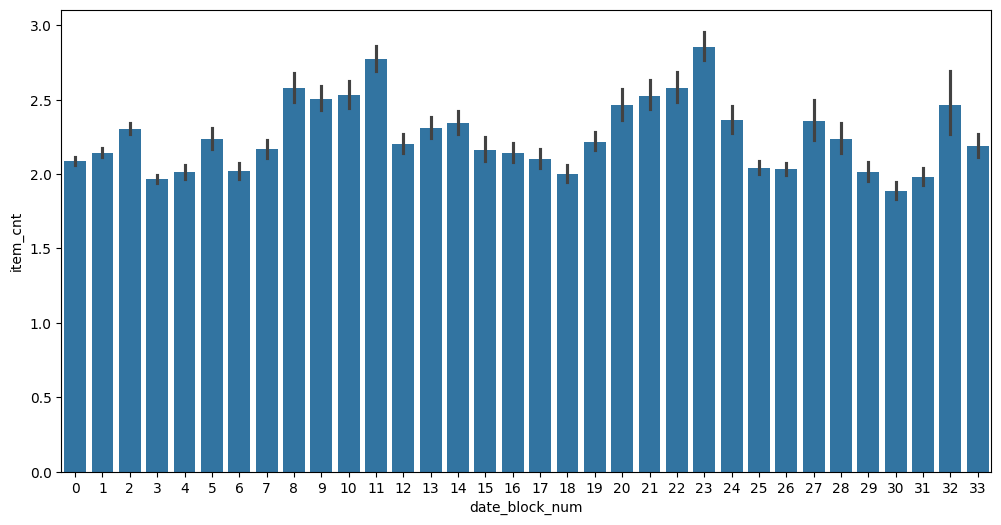

In [24]:
figure, ax = plt.subplots()
figure.set_size_inches(12, 6)
sns.barplot(x='date_block_num', y='item_cnt', data=data)

# Let's transform shop_name and category_name and look at the distribution of sales by category and city

In [25]:
data['item_category_name'] = data['item_category_name'].apply(lambda name: re.sub(r'[^\w\s]', '', str(name).split()[0]).strip())
data['shop_name'] = data['shop_name'].apply(lambda name: re.sub(r'[^\w\s]', '', str(name).split()[0]).strip())

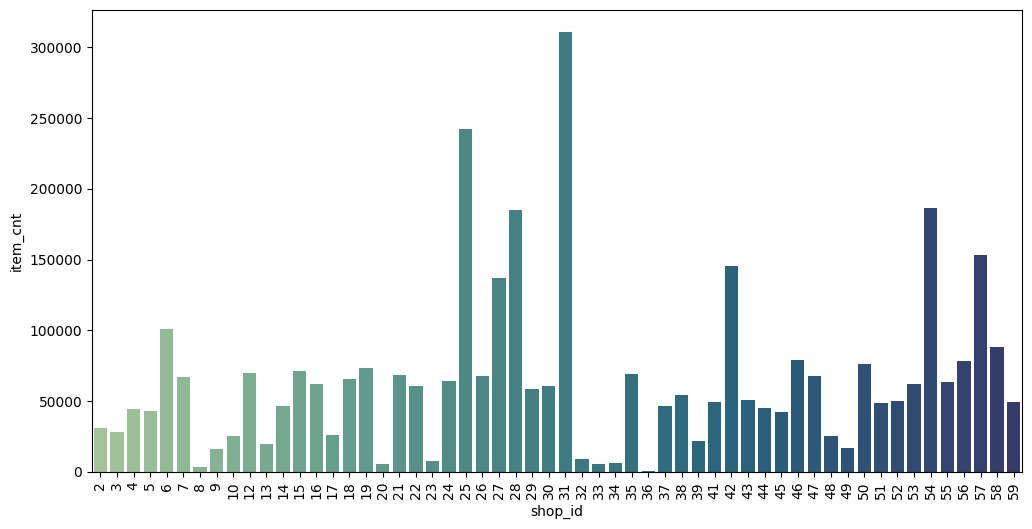

In [35]:
gp_shop_sum = data.groupby(['shop_id'], as_index=False)['item_cnt'].sum()
figure, ax = plt.subplots()
figure.set_size_inches(12, 6)
sns.barplot(x='shop_id', y='item_cnt', data=gp_shop_sum, palette="crest")
plt.xticks(rotation=90)
plt.show()

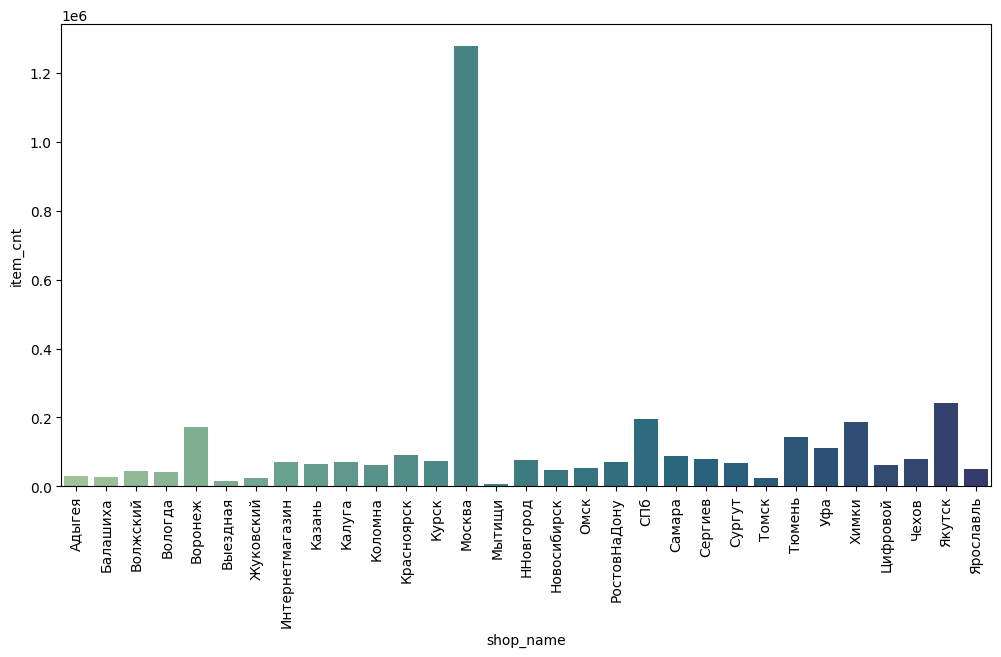

In [30]:
gp_shop_sum = data.groupby(['shop_name'], as_index=False)['item_cnt'].sum()
figure, ax = plt.subplots()
figure.set_size_inches(12, 6)
sns.barplot(x='shop_name', y='item_cnt', data=gp_shop_sum, palette="crest")
plt.xticks(rotation=90)
plt.show()

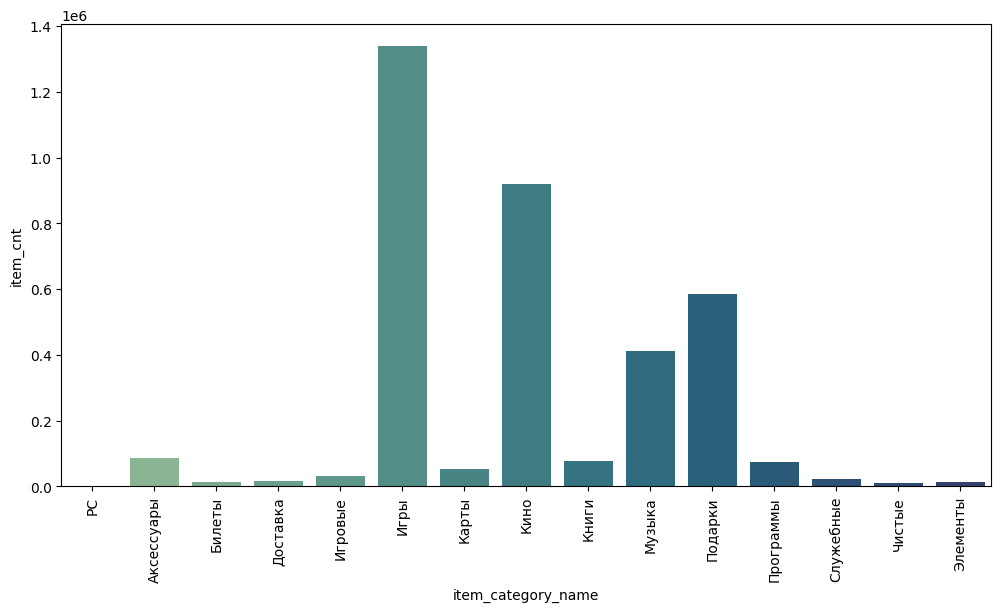

In [32]:
gp_cat_sum = data.groupby(['item_category_name'], as_index=False)['item_cnt'].sum()
figure, ax = plt.subplots()
figure.set_size_inches(12, 6)
sns.barplot(x='item_category_name', y='item_cnt', data=gp_cat_sum, palette="crest")
plt.xticks(rotation=90)
plt.show()

# **Target Variable Distribution**


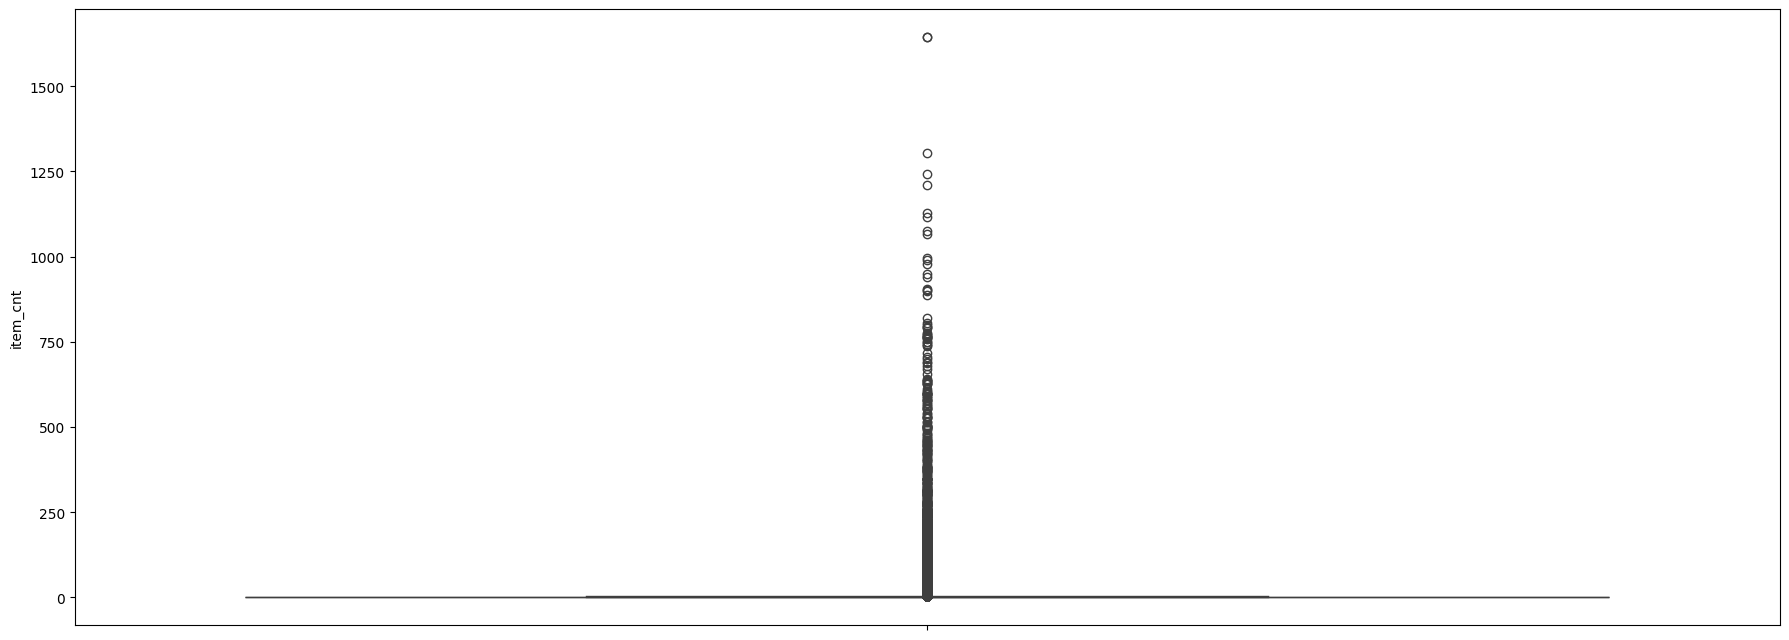

In [37]:
plt.subplots(figsize=(22, 8))
sns.boxplot(data['item_cnt'])
plt.show()

In [39]:
data.head()

,date_block_num,shop_id,item_category_id,item_id,item_category_name,shop_name,item_price_min,item_price_mean,item_cnt
0,0,2,2,5572,Аксессуары,Адыгея,1490.00,1532.86,9
1,0,2,2,5573,Аксессуары,Адыгея,849.00,924.00,2
2,0,2,2,5575,Аксессуары,Адыгея,550.02,955.01,4
3,0,2,2,5576,Аксессуары,Адыгея,2490.00,2490.00,3
4,0,2,2,5632,Аксессуары,Адыгея,2390.00,2390.00,1


In [40]:
def top_10_items(df):
    top_items = df.nlargest(10, 'item_cnt')
    for index, row in top_items.iterrows():
        item_name = row['item_category_name']
        quantity = row['item_cnt']
        mean_quantity = df[df['item_category_name'] == item_name]['item_cnt'].mean()
        print(f"Item name: {item_name}, Quantity: {quantity}, Mean quantity: {mean_quantity}")

top_10_items(data)

Item name: Служебные, Quantity: 1644, Mean quantity: 15.867052023121387
Item name: Билеты, Quantity: 1644, Mean quantity: 43.814696485623
Item name: Подарки, Quantity: 1305, Mean quantity: 2.887170460613492
Item name: Игры, Quantity: 1242, Mean quantity: 3.0343017849447733
Item name: Подарки, Quantity: 1209, Mean quantity: 2.887170460613492
Item name: Игры, Quantity: 1127, Mean quantity: 3.0343017849447733
Item name: Билеты, Quantity: 1117, Mean quantity: 43.814696485623
Item name: Игры, Quantity: 1074, Mean quantity: 3.0343017849447733
Item name: Подарки, Quantity: 1066, Mean quantity: 2.887170460613492
Item name: Подарки, Quantity: 997, Mean quantity: 2.887170460613492


# There are outliers in various categories. It is necessary to clean the dataset from obvious outliers within each category

In [58]:
def filter_outliers(df, column_names, lower_quantile=0.01, upper_quantile=0.99, groupby_column='item_category_name'):
    for column_name in column_names:
        outlier_mask = df.groupby(groupby_column)[column_name].transform(
            lambda x: (x < x.quantile(lower_quantile)) | (x > x.quantile(upper_quantile))
        )
        df = df[~outlier_mask]
    return df

filtered_train = filter_outliers(data, column_names = ['item_cnt'])
print(f'The number of observations after clearing emissions decreased by {len(data) - len(filtered_train)}')

The number of observations after clearing emissions decreased by 12421


# In order not to lose the necessary observations, I decided not to delete observations, but to cut the outlier values ​​to the values ​​of the upper and lower quantiles

In [ ]:
data['item_cnt'] = data.groupby('item_category_name')['item_cnt'].transform(lambda x: x.clip(x.quantile(0.01), x.quantile(0.99)))

In [63]:
top_10_items(data)

Item name: Билеты, Quantity: 713.9695999999999, Mean quantity: 38.942103514376996
Item name: Билеты, Quantity: 713.9695999999999, Mean quantity: 38.942103514376996
Item name: Билеты, Quantity: 713.9695999999999, Mean quantity: 38.942103514376996
Item name: Билеты, Quantity: 713.9695999999999, Mean quantity: 38.942103514376996
Item name: Билеты, Quantity: 707.0, Mean quantity: 38.942103514376996
Item name: Доставка, Quantity: 601.0564, Mean quantity: 78.69403417085427
Item name: Доставка, Quantity: 601.0564, Mean quantity: 78.69403417085427
Item name: Доставка, Quantity: 601.0, Mean quantity: 78.69403417085427
Item name: Билеты, Quantity: 597.0, Mean quantity: 38.942103514376996
Item name: Доставка, Quantity: 578.0, Mean quantity: 78.69403417085427


# I think these positions can no longer be considered outliers, since purely theoretically, ticket sales and delivery may significantly exceed the average in some months

Text(0, 0.5, 'Частота')

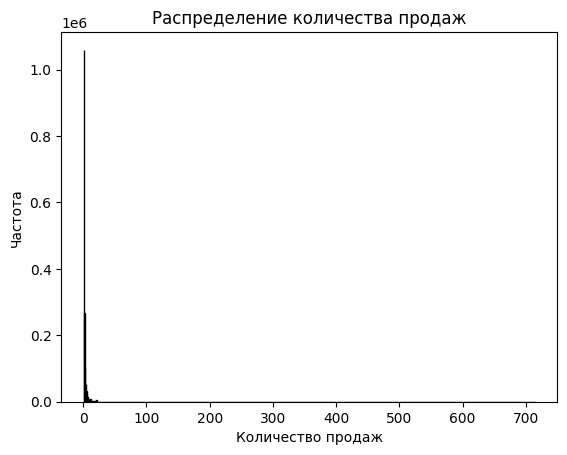

In [61]:
# matplotlib histogram
plt.hist(data['item_cnt'], color = 'blue', edgecolor = 'black',bins = int(1000))
# Add labels
plt.title('Распределение количества продаж')
plt.xlabel('Количество продаж')
plt.ylabel('Частота')

In [62]:
#skewness and kurtosis
print("Skewness: %f" % data['item_cnt'].skew())
print("Kurtosis: %f" % data['item_cnt'].kurt())

Skewness: 68.886170
Kurtosis: 11777.056456


# **Skewness:**

The skewness value is 68.8, which is considerably greater than zero.
A positive skewness value indicates a right-skewed distribution of the data.
This suggests that there is a tail on the right side of the distribution, meaning that there are some unusually large values.

# **Kurtosis:**

The kurtosis value is 11777, which is significantly greater than zero.
A positive kurtosis value indicates a distribution with heavier tails and a sharper peak compared to a normal distribution.


In [64]:
data.describe()

,date_block_num,shop_id,item_category_id,item_id,item_price_min,item_price_mean,item_cnt
count,1608202.00,1608202.00,1608202.00,1608202.00,1608202.00,1608202.00,1608202.00
mean,14.67,33.09,41.55,10681.49,782.50,789.95,2.01
std,9.54,16.47,16.32,6238.88,1511.88,1530.24,3.32
min,0.00,2.00,0.00,0.00,0.07,0.09,1.00
25%,6.00,21.00,30.00,5046.00,199.00,199.00,1.00
50%,14.00,31.00,40.00,10497.00,398.00,399.00,1.00
75%,23.00,48.00,55.00,16060.00,849.00,894.92,2.00
max,33.00,59.00,83.00,22169.00,50999.00,50999.00,713.97


# **Feature Engineering**

In [66]:
from sklearn.preprocessing import LabelEncoder
class FeatureEngineering:

    def __init__(self, start_block_num, end_block_num):
        self.start_block_num = start_block_num
        self.end_block_num  = end_block_num

    def feature_engineering(self, data):
        data = data.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id','item_category_name',
       'shop_name'], as_index=False).agg({'item_price':['min','mean'], 'item_cnt_day':['sum']})
        data.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id','item_category_name',
       'shop_name','item_price_min','item_price_mean','item_cnt']

        # Clip the outlines
        data['item_cnt'] = data.groupby('item_category_name')['item_cnt'].transform(lambda x: x.clip(x.quantile(0.01), x.quantile(0.99)))

        df_pivot = data.pivot_table(
            index = ['shop_id', 'item_category_id', 'item_id','item_category_name',
        'shop_name','item_price_min', 'item_price_mean'],
            columns = 'date_block_num',
            values = 'item_cnt',
            aggfunc='sum').fillna(0.0)
        df_pivot = df_pivot.reset_index()

        # Select columns with a given range
        selected_cols = df_pivot.loc[:, self.start_block_num : self.end_block_num]

        # Create a new item average column
        selected_cols['mean_item_cnt'] = selected_cols.mean(axis=1)

        # return pd.DataFrame(selected_cols)
        data = pd.concat([df_pivot[['shop_id','item_id','item_category_name','shop_name', 'item_category_id', 'item_price_min', 'item_price_mean']], selected_cols], axis=1)

        # Generating features from the text string of the category name and store name
        data['item_category_name'] = data['item_category_name'].apply(lambda name: re.sub(r'[^\w\s]', '', str(name).split()[0]).strip())
        data['shop_name'] = data['shop_name'].apply(lambda name: re.sub(r'[^\w\s]', '', str(name).split()[0]).strip())

        label_encoder = LabelEncoder()
        data['shop_name'] = label_encoder.fit_transform(data['shop_name'])
        data['item_category_name']  = label_encoder.fit_transform(data['item_category_name'])

        # Create 'price_change' column based on conditions
        data['price_change'] = (data['item_price_mean'] > data['item_price_min']).astype(int)
        data = data.drop(labels = ['item_price_min','item_price_mean'],axis=1)

        # Let's find the average lag values ​​for various groups
        # List of columns with names in int format
        num_col_names = [col for col in data.columns if isinstance(col, int)]
        # Grouping by shop_id and item_id, calculating the average
        group_means_shop_item = data.groupby(['shop_id', 'item_id'])[num_col_names].mean().mean(axis=1).reset_index(name='shop_item_cnt_mean')
        # Grouping by shop_id and item_category_id, calculating the average
        group_means_shop_item_category = data.groupby(['shop_id', 'item_category_name'])[num_col_names].mean().mean(axis=1).reset_index(name='shop_item_category_id_cnt_mean')
        # Grouping by shop_name and item_id, calculating the average
        group_means_sity_item_id = data.groupby(['shop_name', 'item_id'])[num_col_names].mean().mean(axis=1).reset_index(name='sity_item_id_cnt_mean')
        # Merging with the original dataframe to add new columns
        data = data.merge(group_means_shop_item, on=['shop_id', 'item_id'], how='left')
        data = data.merge(group_means_shop_item_category, on=['shop_id', 'item_category_name'], how='left')
        data = data.merge(group_means_sity_item_id, on=['shop_name', 'item_id'], how='left')

        return data

train_data = merged_data.copy()
# Создаем экземпляр класса DataProcessor
processor = FeatureEngineering(start_block_num=0,end_block_num=33)

train_data = processor.feature_engineering(train_data)
train_data.shape
# (721361, 44)

(721361, 44)

# **Relationship with numerical variables**

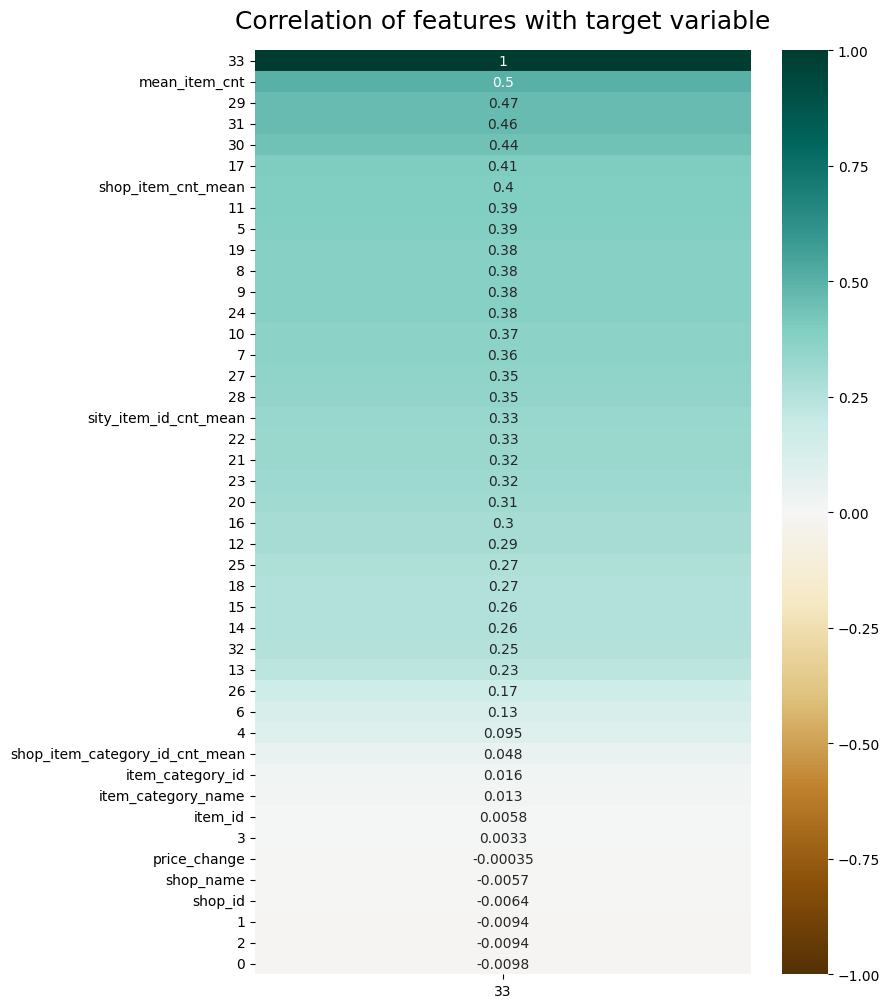

In [74]:
#Correlation of features with mean target variable
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train_data.corr()[[33]].sort_values(by=33, ascending=False)
, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation of features with target variable', fontdict={'fontsize':18}, pad=16);

# If we take sales for the 33rd month as the target variable, then the most significant features are lags 29,30,31,17, 'mean_item_cnt', 'shop_item_cnt_mean